In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import copy
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim



In [2]:
# PREPOCESAMIENTO DE DATOS


# cargar dataset
df_part = pd.read_csv('../../data/partidos_train_ucl_23_todo_24_fg.csv')
df_part.set_index('Match_ID', inplace=True)

# seleccionar variables de interes
df_1 = df_part.copy()
variables = df_1.drop(['Nombre_Eq1','Nombre_Eq2','GANADOR','Year'], axis=1).columns.to_list()
df_1 = df_1[variables]


# ampliar dataset (x4) para ML
df_3 = df_1.copy()
for _ in range(2):
    df_3 = pd.concat([df_3, df_3], axis=0)

print('DATOS LISTOS')
print()


# DIVIDIR TEST Y TRAIN
df_4 = df_3.copy()
caracteristicas = df_4.drop(['Gol_Match_Eq1', 'Gol_Match_Eq2'], axis=1).columns.to_list()
objetivo = ['Gol_Match_Eq1', 'Gol_Match_Eq2']

data_caract = df_4[caracteristicas].values
data_obj = df_4[objetivo].values

print('DATOS TEST Y TRAIN LISTOS')
print()

DATOS LISTOS

DATOS TEST Y TRAIN LISTOS



In [3]:
len(caracteristicas)

30

In [4]:
# División entrenamiento-prueba para evaluación del modelo
X_train, X_test, y_train, y_test = train_test_split(data_caract, data_obj, train_size=0.7, shuffle=True)

# Convertir a tensores 2D de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 2)  # Asegurarse de que y_train tenga 2 columnas
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 2)  # Asegurarse de que y_test tenga 2 columnas

# Definir el modelo
UCL_model = nn.Sequential(
    nn.Linear(len(caracteristicas), 300),  # Entrada de 30 características
    nn.ReLU(),
    nn.Linear(300, 150),
    nn.ReLU(),
    nn.Linear(150, 75),
    nn.ReLU(),
    nn.Linear(75, 2)  # Salida de 2 variables objetivo
)

# Función de pérdida y optimizador
loss_fn = nn.MSELoss()  # Error cuadrático medio
optimizer = optim.Adam(UCL_model.parameters(), lr=0.0001)

n_epochs = 100   # Número de épocas
batch_size = 10  # Tamaño de cada lote
batch_start = torch.arange(0, len(X_train), batch_size)

# Guardar el mejor modelo
best_mse = np.inf   # Inicializar a infinito
best_weights = None
history = []

for epoch in range(n_epochs):
    UCL_model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            end = min(start + batch_size, len(X_train))  # Ajuste para el último lote
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            # Paso hacia adelante
            y_pred = UCL_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Paso hacia atrás
            optimizer.zero_grad()
            loss.backward()
            # Actualizar pesos
            optimizer.step()
            bar.set_postfix(mse=float(loss))
    # Evaluar precisión al final de cada época
    UCL_model.eval()
    y_pred = UCL_model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(UCL_model.state_dict())
        torch.save(best_weights, 'best_model.pth') # guardar el mejor modelo con mejores pesos

# Restaurar modelo a la mejor precisión
UCL_model.load_state_dict(best_weights)


<All keys matched successfully>

MSE: 1.08
RMSE: 1.04


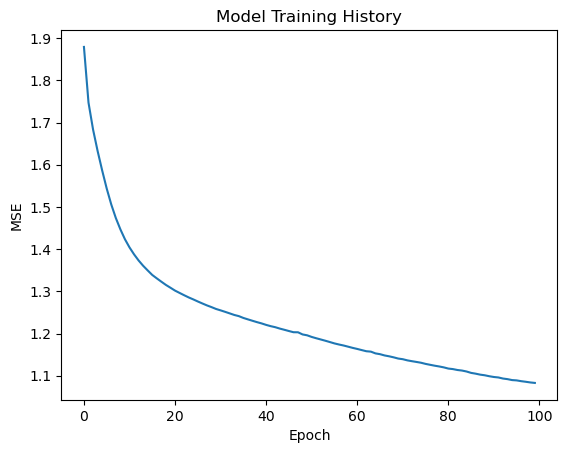

In [5]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model Training History')
plt.show()

In [6]:
# Restaurar modelo a la mejor precisión
UCL_model.load_state_dict(best_weights)

# Guardar modelo
model_file = 'goal_regression_dnn_2.pth'
torch.save(UCL_model.state_dict(), model_file)
#del UCL_model
print('model saved as', model_file)

model saved as goal_regression_dnn_2.pth


## Predicciones

In [7]:
def predecir_resultado(model, feature_vector):
    
    model.eval()  # Poner el modelo en modo de evaluación
    # Convertir el vector de características a tensor de PyTorch
    # Asegúrate de que el vector de entrada sea de tipo float32
    if isinstance(feature_vector, list):
        feature_vector = np.array(feature_vector)
    feature_tensor = torch.tensor(feature_vector, dtype=torch.float32).unsqueeze(0)  # Añadir una dimensión batch
    
    with torch.no_grad():  # Desactivar el seguimiento de gradientes
        predictions = model(feature_tensor)  # Obtener las predicciones del modelo
        # Convertir las predicciones a un array de numpy para facilitar su manipulación
        predictions = predictions.numpy()
        
    return predictions


def resultado_media_final(eq1, eq2):
    '''media de partido de ida y de vuelta'''
    eq1_eq2 = predecir_resultado(UCL_model, eq1+eq2)[0]
    eq2_eq1 = predecir_resultado(UCL_model, eq2+eq1)[0]
    goles_eq1 = [eq1_eq2[0], eq2_eq1[1]]
    goles_eq2 = [eq1_eq2[1], eq2_eq1[0]]

    media_eq1 = np.mean(goles_eq1).round(3)
    media_eq2 = np.mean(goles_eq2).round(3)

    return media_eq1, media_eq2


def resultado_acumulado(eq1, eq2):
    '''media de partido de ida y de vuelta'''
    eq1_eq2 = predecir_resultado(UCL_model, eq1+eq2)[0]
    eq2_eq1 = predecir_resultado(UCL_model, eq2+eq1)[0]
    goles_eq1 = [eq1_eq2[0], eq2_eq1[1]]
    goles_eq2 = [eq1_eq2[1], eq2_eq1[0]]

    sum_eq1 = np.sum(goles_eq1).round(3)
    sum_eq2 = np.sum(goles_eq2).round(3)

    return sum_eq1, sum_eq2


def imprimir_resultados(eq1, eq2):
    print('Resultado IDA:', predecir_resultado(UCL_model, eq1+eq2))
    print('Resultado VUELTA:', predecir_resultado(UCL_model, eq2+eq1))
    print('Resultado acumulado:', resultado_acumulado(eq1, eq2))
    print('Media Goles:', resultado_media_final(eq1, eq2))

### Octavos

In [8]:
psg = [1.55,1.13,2.68,1.4,2.53,23.48,2.57,13.07,4.39,0.25,0.08,0.23,0.86,0.54,3.82]
real_soc = [0.82,0.54,1.36,0.8,1.34,16.7,1.31,9.38,3.03,0.22,0.06,0.18,0.49,0.51,2.48]

imprimir_resultados(psg, real_soc)

Resultado IDA: [[1.1026727  0.32782006]]
Resultado VUELTA: [[0.7270112 0.8661874]]
Resultado acumulado: (1.969, 1.055)
Media Goles: (0.984, 0.527)


In [9]:
copenh = [1.18,0.8,1.97,1.08,1.87,17.35,2.04,9.58,3.3,0.26,0.08,0.25,1.12,0.52,4.42]
city = [2.09,1.56,3.65,1.82,3.38,26.29,3.86,14.26,5.28,0.28,0.1,0.26,0.68,0.48,2.23]

imprimir_resultados(copenh, city)

Resultado IDA: [[0.8526349 1.2867708]]
Resultado VUELTA: [[2.1815934 0.6814328]]
Resultado acumulado: (1.534, 3.468)
Media Goles: (0.767, 1.734)


In [10]:
barca = [1.39,1.26,2.66,1.38,2.64,21.04,2.44,12.06,4.15,0.26,0.09,0.25,0.67,0.53,2.53]
napoli = [1.02,0.53,1.55,0.9,1.43,19.86,1.74,10.84,3.28,0.23,0.06,0.21,1.0,0.52,3.78]

imprimir_resultados(barca, napoli)

Resultado IDA: [[1.9280853 0.4516288]]
Resultado VUELTA: [[0.31034094 1.1332766 ]]
Resultado acumulado: (3.061, 0.762)
Media Goles: (1.531, 0.381)


In [11]:
atl_mad = [1.56,1.01,2.57,1.53,2.54,18.95,2.47,10.24,3.66,0.27,0.12,0.32,0.79,0.56,3.46]
inter = [1.22,0.77,1.99,0.94,1.71,19.86,2.07,10.88,3.47,0.24,0.06,0.2,0.58,0.6,3.11]

imprimir_resultados(atl_mad, inter)

Resultado IDA: [[0.96975124 0.66662556]]
Resultado VUELTA: [[0.78541803 0.94186985]]
Resultado acumulado: (1.912, 1.452)
Media Goles: (0.956, 0.726)


In [12]:
dortmund = [1.17,0.92,2.09,1.03,1.95,19.19,2.12,10.7,3.58,0.25,0.07,0.21,0.57,0.6,2.74]
psv = [1.12,0.75,1.87,0.95,1.7,21.29,1.98,11.64,4.12,0.27,0.06,0.16,1.09,0.46,3.06]

imprimir_resultados(dortmund, psv)

Resultado IDA: [[1.3110951  0.40769053]]
Resultado VUELTA: [[0.7164422 1.0676521]]
Resultado acumulado: (2.379, 1.124)
Media Goles: (1.189, 0.562)


In [13]:
bay_munch = [1.28,1.0,2.28,1.18,2.18,19.23,2.11,10.82,3.2,0.22,0.08,0.28,0.7,0.57,2.74]
lazio = [0.78,0.5,1.28,0.62,1.12,15.22,1.35,8.49,2.48,0.22,0.06,0.19,0.91,0.52,3.56]

imprimir_resultados(bay_munch, lazio)

Resultado IDA: [[1.5208567  0.43677932]]
Resultado VUELTA: [[0.31042504 0.8959473 ]]
Resultado acumulado: (2.417, 0.747)
Media Goles: (1.208, 0.374)


In [14]:
arsenal = [1.6,1.26,2.86,1.49,2.75,16.63,2.76,9.26,3.58,0.29,0.12,0.32,0.65,0.55,2.66]
porto = [1.66,1.23,2.88,1.53,2.77,18.7,2.67,10.46,4.36,0.32,0.11,0.26,0.88,0.53,3.11]

imprimir_resultados(arsenal, porto)

Resultado IDA: [[1.0240253  0.76986325]]
Resultado VUELTA: [[1.0214046 0.9666132]]
Resultado acumulado: (1.991, 1.791)
Media Goles: (0.995, 0.896)


In [15]:
real_mad = [1.57,1.35,2.92,1.53,2.88,24.5,2.98,13.2,4.48,0.22,0.08,0.23,0.58,0.54,3.3]
lepizig = [1.21,1.06,2.27,1.18,2.25,17.27,2.04,10.46,3.61,0.23,0.07,0.22,0.92,0.42,3.08]

imprimir_resultados(real_mad, lepizig)

Resultado IDA: [[1.5627868 0.4820223]]
Resultado VUELTA: [[0.5000466 1.0450275]]
Resultado acumulado: (2.608, 0.982)
Media Goles: (1.304, 0.491)


### Cuartos

In [16]:
imprimir_resultados(dortmund, atl_mad)

Resultado IDA: [[0.8637737 0.9140062]]
Resultado VUELTA: [[0.75388074 0.6741113 ]]
Resultado acumulado: (1.538, 1.668)
Media Goles: (0.769, 0.834)


In [17]:
imprimir_resultados(barca, psg)

Resultado IDA: [[1.2733494  0.84712964]]
Resultado VUELTA: [[0.8505269 0.6933552]]
Resultado acumulado: (1.967, 1.698)
Media Goles: (0.983, 0.849)


In [18]:
imprimir_resultados(bay_munch, arsenal)

Resultado IDA: [[1.0336447 0.8955711]]
Resultado VUELTA: [[0.96620107 0.5523197 ]]
Resultado acumulado: (1.586, 1.862)
Media Goles: (0.793, 0.931)


In [19]:
imprimir_resultados(real_mad, city)

Resultado IDA: [[1.081898  0.8754979]]
Resultado VUELTA: [[1.7329878 0.8763104]]
Resultado acumulado: (1.958, 2.608)
Media Goles: (0.979, 1.304)


### Semis

In [20]:
imprimir_resultados(barca, atl_mad)

Resultado IDA: [[1.3288175 0.8450395]]
Resultado VUELTA: [[0.61161375 0.77488446]]
Resultado acumulado: (2.104, 1.457)
Media Goles: (1.052, 0.728)


In [21]:
imprimir_resultados(arsenal, city)

Resultado IDA: [[0.6313411 1.1033028]]
Resultado VUELTA: [[1.6377714  0.61382365]]
Resultado acumulado: (1.245, 2.741)
Media Goles: (0.623, 1.371)


### Final

In [22]:
imprimir_resultados(barca, city)

Resultado IDA: [[0.66868806 1.0303603 ]]
Resultado VUELTA: [[1.7116736  0.58701944]]
Resultado acumulado: (1.256, 2.742)
Media Goles: (0.628, 1.371)
